# Gene Ontology (GO) Term Embedding with Fine-Tuned Text Transformers

High-throughput [DNA sequencing](https://en.wikipedia.org/wiki/DNA_sequencing#High-throughput_sequencing_(HTS)_methods) has give us the power to sequence the entire genome of a species within a day. With the sequence on hands, we can deploy **computational models to identify and annotate genes** based on their characteristics, attributing correct functions and subcellular locations of the gene product given the gene sequence. For example, the [Critical Assessment of Protein Function Annotation (CAFA)](https://www.cell.com/trends/genetics/fulltext/S0168-9525(13)00166-2) competition engages the data science community in enhancing protein prediction by utilizing features derived from the Gene Ontology (GO) graph.

The [Gene Ontology (GO)](https://geneontology.org/docs/ontology-documentation/) is a directed knowledge graph where **each node represents a specific GO term**, defining a particular aspect of genes and their products. The GO terms are categorized into three major aspects:

- <font color="grey">***Molecular Function (MF)***</font>: These terms define the **activities** performed by gene products, such as *catalysis* or *transport*. These functions can be further refined by more specific GO terms, for example, "protein kinase activity" within the broader category of "catalysis".

- <font color="grey">***Cellular Component (CC)***</font>: These terms specify the subcellular **locations** of gene products, including compartments like *chloroplast* or *nucleus*, as well as macromolecular complexes like *proteasome* or *ribosome*.

- <font color="grey">***Biological Process (BP)***</font>: These terms delineate the biological **pathways** in which gene products are involved, ranging from 'DNA repair' and 'carbohydrate metabolic process' to overarching processes like *biosynthetic processes*.

The terms are **hierarchically organized nodes with edges connecting terms based on their relationships**. For more information about how the GO graph is structured, please refer to my previous post [GO-graph-EDA](https://github.com/matiollipt/GO-graph-EDA) and the [Gene Ontology reference](https://geneontology.org/docs/ontology-documentation). For now, it is essential to know that **each node representing a GO term has specific attributes**.

A feature often overlooked when deploying the GO graph to assist in the prediction and classification of gene functions is the **textual definition of each GO term**. For example, the GO term ID [GO:0015986](https://www.ebi.ac.uk/QuickGO/term/GO:0015986) is defined as *"The transport of protons across the plasma membrane to generate an electrochemical gradient (proton-motive force) that powers ATP synthesis."*, along with other attributes shown below:

---
 **GO id**: GO:0015986

- **name**: 'proton motive force-driven plasma membrane ATP synthesis'
- **namespace**: 'biological_process'
- **def**: '"The transport of protons across the plasma membrane to generate an electrochemical gradient (proton-motive force) that powers ATP synthesis." [GOC:mtg_sensu, ISBN:0716731363]'
- **synonym**: ['"ATP synthesis coupled proton transport" BROAD []', '"plasma membrane ATP synthesis coupled proton transport" EXACT []']
 - **is_a**: ['GO:0015986']}

 ---

In this tutorial, we will use the text definitions of GO terms to **fine-tune** a pre-trained Large Language Model (LLMs) based on [transformer architecture](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)). The transformer architecture, proposed by the [Google Brain Team](https://research.google/) in the seminal paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762), revolutionized [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) by introducing the idea of using solely **attention mechanisms** to identify dependencies between words and sentences in a text.

**Transformers** have gained significant attention in the machine learning landscape, contributing to the development of generative models like [chatGPT](https://chat.openai.com). Text transformer-based architectures are specifically engineered to analyze the relationships between words in sentences, considering their positions to accuratelly capture the meaning of the text. This capability is instrumental in tasks such as text classification and ranking, as well as enabling generative models to generate new sentences in response to queries.

>**Fine-tunning** is a powerful tecnique in machine learning that consists in using models that underwent **semi-supervised training** on extensive data from different sources. This step teachs the model the underlying semantic features of the language. After pre-training, the model is trained in a **supervised manner** aiming at a specific task such as text generation, classification or label prediction (identify emails regarding they are spam or not, for example). This task is done by keeping the deeper encoded features of the pre-trained model but adjusting the trainable parameters of the output layer(s), which can be a feed-forward neural network for binary classification of "spam" vs "not spam". These steps encompass the concept of [Transfer Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/), a powerful machine learning technique that involves adapting knowledge learned from one task to be applied effectively to another task.

Our exercise is to leverage this LLM to **categorize GO term definitions** based on their alignment with the major GO ontologies (BP, CC, and MF). Additionally, we will extract **text embeddings** from GO term definitions to serve as supplementary data for training models aimed at predicting protein annotations.

In [1]:
# install required libraries (uncomment these lines for Colab or Kaggle)

# !pip install obonet
# !pip install nltk
# !pip install transformers
# !pip install datasets
# !pip install wordcloud
# !pip install bertviz

In [2]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import networkx as nx
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from wordcloud import WordCloud
from tqdm.notebook import tqdm_notebook


# set progress bar for loops
tqdm_notebook.pandas()

# download / update punkt, the nltk's recommended sentences' tokenizer
import nltk

nltk.download("punkt")

# set home directory
from pathlib import Path

home_dir = Path("../GO-graph-definition-text-transformer/")
print(f"Home directory: {home_dir.as_posix()}")

Home directory: ../GO-graph-definition-text-transformer


[nltk_data] Downloading package punkt to /home/clever/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# convenience functions for this notebook


# plot confusion matrix
def plot_cm(y_true: pd.Series, y_pred: pd.Series):
    # print out the balanced accuracy score
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_pred, y_true):.1%}")

    # create normalized confusion matrix
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred",
    )

    # convert to dataframe for easy plotting
    cm_df = pd.DataFrame(
        cm,
        index=["Biological Process", "Cellular Component", "Molecular Function"],
        columns=["Biological Process", "Cellular Component", "Molecular Function"],
    )

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(
        data=cm_df,
        annot=True,
        cmap="Blues",
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


# plot graphs or sub-graphs
def plot_graph(
    G: nx.Graph(),
    plot_nodes=list,
    plot_all=False,
    num_nodes=100,
    iterations=100,
    figure_size=(8, 8),
    node_color="green",
    font_color="black",
):
    """
    Plot the full graph (plot_all=True) or a sub-graph with the
    nodes passed as parameter. The 'n_terms' parameter controls
    how many nodes will be plotted in the top-down list of nodes.

    G: nx.Graph
    plot_nodes: list with the nodes to plot
    plot_all: select wheter plot the full graph or a subgraph
    n_nodes: number of nodes to plot
    iterations: number of iterations of spring_layout algorithm
    figure_size: tuple with figure dimensions (W x H)
    node_color: specify node color
    """
    if plot_all:
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)

    else:
        G = nx.subgraph(G, plot_nodes[:num_nodes])
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)

    # set figure size
    rcParams["figure.figsize"] = figure_size

    # nodes features
    degree_dict = dict(G.degree)  # get degree to adjust node viz
    node_size = list([x * 100 for x in degree_dict.values()])
    node_alpha = [float(x / max(degree_dict.values())) for x in degree_dict.values()]

    pos = nx.spring_layout(
        G,
        scale=10,
        k=25 / np.sqrt(n_nodes),
        seed=13,
        iterations=iterations,
    )

    ax = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, alpha=node_alpha, node_color=node_color
    )

    ax = nx.draw_networkx_edges(
        G, pos, width=0.5, node_size=node_size, edge_color="grey"
    )

    ax = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color=font_color,
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.title(f"Graph plot with {G.order()} nodes and {G.size()} edges")
    plt.axis("off")
    plt.show()

## Dataset Preparation

Our initial step involves pre-processing the dataset to make it compatible with the pre-trained model that we are going to fine-tune according to our needs. One model that fits our task requirements is the [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased), based on the well-known [Bidirectional Encoder Representations from Transformers (BERT)](https://huggingface.co/docs/transformers/model_doc/bert) architecture. This model has previously undergone **semi-supervised training** on an extensive dataset comprising millions of entries from [Wikipedia](https://www.wikipedia.org/) in 102 different languages. During this pre-training phase, the model learns language rules and dependencies, setting the stage for its application in various **supervised training** scenarios. These applications include tasks like sentiment analysis, text generation, text sequence classification, and, in our specific case, identifying the major GO ontology categories (BP, CC, and MF) for the given text sequences.

To prepare the dataset for fine-tuning our model, we will perform the following tasks:

1. **Feature Extraction**: In this step, we convert the attributes associated with each GO term's nodes into a Pandas DataFrame. This conversion streamlines the creation of pre-processed and tokenized datasets that will be used to train the model. We will focus on extracting only the text definitions and labels corresponding to the aspects we aim to predict (BP, MF, and CC).

2. **Dataset Creation and Splitting**: Our data will be divided into two subsets: a training set (70%) and a test set (30%). These sets will contain the input text derived from the definitions of GO terms.

3. **Text Tokenization**: The input text undergoes a tokenization process, breaking it into smaller units known as tokens. Special tokens are also incorporated to indicate the start and end of sequences and sentences. This step is crucial for enabling the model to comprehend the text.

To create and manage these datasets, we will make use of the [Dataset](https://huggingface.co/docs/datasets/index) library provided by Hugging Face. Additionally, as our project progresses, we will leverage pre-trained sequence classification models and their corresponding tokenizers, which are also available from [Hugging Face](https://huggingface.co/).

### Feature Extraction

The GO graph is stored in the *OBO (Open Biomedical Ontologies) file format*, designed specifically for the construction and representation of biological ontologies. To convert this file format into a **NetworkX** object, we can utilize the Python library [obonet](https://github.com/dhimmel/obonet). [NetworkX](https://networkx.org/) offers a robust framework for graph manipulation and analysis. Below, we demonstrate how to load the GO graph and visualize nodes with high degrees:

The GO graph is a MultiDiGraph named 'go' with 43248 nodes and 84805 edges.


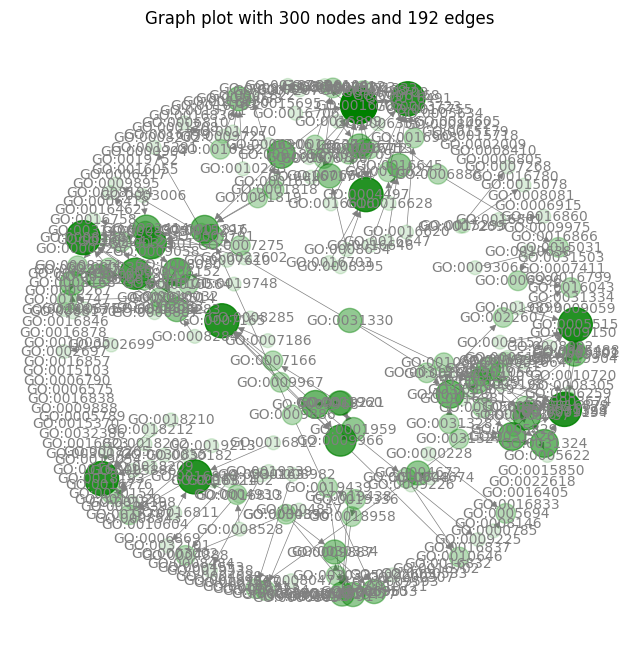

In [4]:
from obonet import read_obo

# read and parse GO graph data
go_graph = read_obo(home_dir.joinpath("data/go-basic.obo"))
print(f"The GO graph is a {go_graph}.")

# select nodes with high degree: the list comprehension yields
# GO graph nodes with degree higher than 20, # i.e., only nodes 
# with more than 20 connected neighbors, for plotting.
node_list = [n for n in go_graph.nodes() if go_graph.degree(n) > 20]

# plot subgraph
plot_graph(
    G=go_graph,
    plot_nodes=node_list,
    plot_all=False,
    num_nodes=300,
    iterations=500,
    font_color="grey",
)

Recall from above that the nodes encompass attributes describing the corresponding GO terms. By running the cell above a couple of times, you start to notice that all GO terms contain the following essential attributes:

>***name***: unique identifier of the term in a human-readable format

>***namespace***: one of the three major ontologies (MF, CC or BP) to which the term belongs

>***definition***: a short description of what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

There are additional attributes of each node corresponding to GO terms, but we won't be using them in this project.

In [5]:
go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'formaldehyde transketolase activity',
 'namespace': 'molecular_function',
 'def': '"Catalysis of the reaction: D-xylulose 5-phosphate + formaldehyde = glyceraldehyde 3-phosphate + glycerone." [EC:2.2.1.3, MetaCyc:FORMALDEHYDE-TRANSKETOLASE-RXN]',
 'synonym': ['"D-xylulose-5-phosphate:formaldehyde glycolaldehydetransferase activity" RELATED [EC:2.2.1.3]',
  '"DHAS activity" RELATED [EC:2.2.1.3]',
  '"dihydroxyacetone synthase activity" RELATED [EC:2.2.1.3]',
  '"glycerone synthase activity" RELATED [EC:2.2.1.3]'],
 'xref': ['EC:2.2.1.3',
  'MetaCyc:FORMALDEHYDE-TRANSKETOLASE-RXN',
  'RHEA:24264'],
 'is_a': ['GO:0016744']}

Our upcoming task involves **extracting attributes from GO graph nodes and structuring them into a dataframe**. This process aims to facilitate the handling of text definitions. Additionally, we will include a column indicating the word count for each definition and visualize the distribution of these counts. This distribution will provide valuable insights for choosing optimal hyperparameters for tokenization (i.e., breaking the text into individual words or tokens) and fine-tuning our selected pre-trained model.

Looking at the sample GO term above, the *definition* ('*def*') is not purely textual. Here is the definition of the GO term **GO:0150058** as another example:

<font color="grey">'def': '<u>"A G protein-coupled receptor complex that serves as a receptor for amylin polypeptide (AMY) and consists of a calcitonin receptor (CTR/CALCR) and a receptor activity-modifying protein (RAMP) 3. Amylin receptor complex 3 (AMY3) also serves as a receptor for the amyloid-beta complex. Ligand binding to AMY3 results in increased cytosolic calcium ion levels and in activation on multiple intracellular signalling pathways."</u> [GOC:aruk, GOC:bc, PMID:22500019]'</font>

We intend to extract only the textual description from the definition to input the model during the fine-tuning step. Therefore, we need to split the text using appropriate separators and employ indexes to access the desired information. Let's examine the content of a single node to understand how to extract its contents. Please note that the nodes' attributes are stored in a tuple where the first element is the GO term ID, and the second is a dictionary containing the respective attributes.

In [6]:
for item in go_graph.nodes.items():
    print(f"type: {type(item)}")
    print(f"item: {item}")
    print(f"GO term id: {item[0]}")
    print(f"attributes: {item[1]}")
    break

type: <class 'tuple'>
item: ('GO:0000001', {'name': 'mitochondrion inheritance', 'namespace': 'biological_process', 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]', 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is_a': ['GO:0048308', 'GO:0048311']})
GO term id: GO:0000001
attributes: {'name': 'mitochondrion inheritance', 'namespace': 'biological_process', 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]', 'synonym': ['"mitochondrial inheritance" EXACT []'], 'is_a': ['GO:0048308', 'GO:0048311']}


  0%|          | 0/43248 [00:00<?, ?it/s]

,go_id,name,aspect,definition,def_word_count
0,GO:0000001,mitochondrion inheritance,biological_process,"The distribution of mitochondria, including th...",23
1,GO:0000002,mitochondrial genome maintenance,biological_process,The maintenance of the structure and integrity...,19
2,GO:0000003,reproduction,biological_process,The production of new individuals that contain...,19
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,Enables the transfer of zinc ions (Zn2+) from ...,44
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,Enables the transfer of a solute or solutes fr...,50


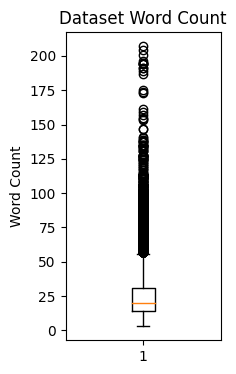

In [7]:
# create GO definitions dataframe

# create empty dataframe to store nodes' attributes
go_df = pd.DataFrame(
    columns=["go_id", "name", "aspect", "definition", "def_word_count"]
)

# iterate over nodes to extract dictionary keys and values
n_rows = len(go_graph.nodes)

for idx, item in tqdm_notebook(
    enumerate(go_graph.nodes.items()), total=n_rows
):
    go_term = item[0]
    name = item[1]["name"]
    aspect = item[1]["namespace"]

    # split 'def' content and get the text definition only
    definition = item[1]["def"].split(sep='"', maxsplit=2)[1]

    # count the number of words of the text we just extracted
    def_word_count = len(re.findall(r"\w+", definition))

    go_df.loc[idx] = [
        go_term,
        name,
        aspect,
        definition,
        def_word_count,
    ]

# save dataframe
home_dir.joinpath("data/").mkdir(parents=True, exist_ok=True)
go_df.to_csv(home_dir.joinpath("data/go_df.csv"), index=False)

display(go_df.head())

# word counts boxplot
plt.figure(figsize=(2, 4))
plt.title("Dataset Word Count")
plt.boxplot(go_df.def_word_count.values)
plt.ylabel("Word Count")
plt.show()

Before proceeding, we will make some modifications in our dataset: renaming the **definition** column to *text*, converting the **aspect** column to a **categorical data type** while mapping the aspects to numeric labels and keeping only these two columns for the downstream tasks.

In [8]:
# loading saved dataframe with GO graph nodes' attributes

# load saved GO dataframe
go_df = pd.read_csv(home_dir.joinpath("data/go_df.csv"))

# convert categorical labels to numbers (aspect)
go_df["aspect"] = pd.Categorical(go_df["aspect"])

# get categorical codes
go_df["label"] = go_df["aspect"].cat.codes

# select only relevant columns
data = go_df[["definition", "label"]].copy()

# rename definition column
data.rename(columns={"definition": "text"}, inplace=True)

print(f"Dataset dimensions: {data.shape}")
display(data.head())

# print label mapping for reference
print("\nCode: label")
for code, aspect in enumerate(go_df.aspect.cat.categories):
    print(f"{code}: {aspect}")

Dataset dimensions: (43248, 2)


,text,label
0,"The distribution of mitochondria, including th...",0
1,The maintenance of the structure and integrity...,0
2,The production of new individuals that contain...,0
3,Enables the transfer of zinc ions (Zn2+) from ...,2
4,Enables the transfer of a solute or solutes fr...,2



Code: label
0: biological_process
1: cellular_component
2: molecular_function


We can visualize the most common terms in the dataset by creating a [word cloud](http://amueller.github.io/word_cloud/). This visual representation is quite helpful in identifying the most frequently occurring words in a given text:

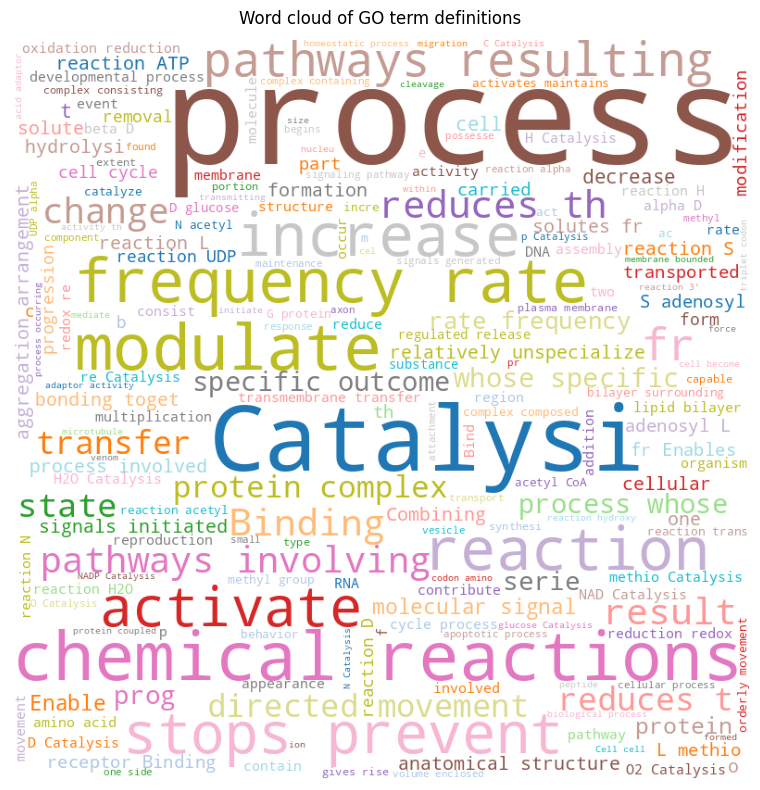

In [9]:
go_wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=10,
    colormap="tab20",
    random_state=13,
).generate(data.text.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Word cloud of GO term definitions")
plt.imshow(go_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

### Dataset Creation and Splitting

To construct the dataset containing our text sequences and corresponding labels for fine-tuning the model, we will leverage the [Dataset](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset) class provided by Hugging Face. Using its built-in dataset split method, we will create distinct training and testing sets. We will ensure that the sampling is stratified by label. This stratification is crucial as it preserves the distribution of the GO ontologies, ensuring a representative balance in our datasets.

In [34]:
from datasets import Dataset

# create dataset
dataset = Dataset.from_pandas(data)

# change label column to ClassLabe to allow stratification
dataset = dataset.class_encode_column("label")

# split the dataset into train (70%) / test (30%)
dataset = dataset.train_test_split(test_size=0.3, stratify_by_column="label")
dataset

Stringifying the column:   0%|          | 0/43248 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/43248 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12975
    })
})

### Text Tokenization

The **tokenization strategy must align with the chosen model**. This is crucial to ensure that tokens are mapped to the **same indices** presented to the model during training and that the **same special tokens** are used to denote the beginning of a text sequence and the separation between sentences. We also need to handle inputs that are longer or shorter than the input accepted by the model, or defined by us when we initialize the tokenizer.

> **Handling text input length with truncation and padding strategy**: The model accepts fixed-sized tensors for training and evaluation. To ensure that we feed the model with fixed-sized tensors, the tokenizer handle sequences of varying lengths by truncating and padding longer and shorter text sequences, respectively. If the *truncation* parameter is set to 'True,' input sequences longer than a defined length will be truncated. Conversely, if the sequences are shorter, the special padding token [PAD] will be added until the number of tokens in the input matches our requirements for the model of choice. Truncation and padding are pivotal in guaranteeing consistent input sizes, as the inputs for the model we chose are predefined fixed-size tensors (e.g., 510 tokens + 2 special tokens [CLS] and [SEP] = 512). For our **fine-tunning** task, setting the input maximum length to 150 tokens encompass the majority of the samples and expedite the tokenization process.

**Classification Token [CLS]** and **Separator Token [SEP]** are special tokens that provide information about the input provided to the model we choose. [CLS] marks the initiation of the sequence for the BERT model. [SEP] separates sentences in sentence-pair tasks. It aids the model in capturing the relationships between two sentences that are concatenated using [SEP]. Note the use of padding [PAD] to fill-up the input sequence to a fixed length. 

In this context, we are employing the [BertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizerFast) with the tokenization strategy of the pre-trained model [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) to convert text to lowercase and eliminate capitalization. Lowercase inputs typically result in a smaller number of tokens and tend to generalize better for unseen text sequences during production phase. However, we can later explore the possibility of using cased inputs to evaluate model performance.

As indicated by the boxplot above, all GO term definitions conform to the input size requirements for fine-tuning (510 tokens). Nonetheless, we might consider limiting the input length to expedite the fine-tuning process. To proceed, we will create the dataset with training and test sets using Hugging Face's Dataset library. We will employ stratification to maintain the distribution of labels between datasets.

In [35]:
from transformers import BertTokenizerFast

# initiate tokenizer with parameters from the pre-trained model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-uncased")

# define tokenize function to be applied to the input
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, max_length=150, truncation=True)

# tokenize dataset 
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/30273 [00:00<?, ? examples/s]

Map:   0%|          | 0/12975 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12975
    })
})

In [12]:
print("Dataset features:")
print("text:", tokenized_dataset["train"]["text"][0])
print("label:", tokenized_dataset["train"]["label"][0])
print("input_ids:", tokenized_dataset["train"]["input_ids"][0])
print("token_type_ids:", tokenized_dataset["train"]["token_type_ids"][0])
print("attention_mask:", tokenized_dataset["train"]["attention_mask"][0])

Dataset features:
text: The process whose specific outcome is the progression of the slug over time, from its formation to the mature structure. Slug development begins when the aggregate rises upwards to form a finger-shaped structure and ends when culmination begins. Slug development begins after aggregation and ends before culmination in sorocarp development.
label: 0
input_ids: [101, 10103, 14936, 17060, 18974, 80196, 10127, 10103, 70105, 10108, 10103, 25410, 22557, 10323, 10573, 117, 10195, 10491, 15112, 10114, 10103, 60773, 13519, 119, 25410, 22557, 12077, 24318, 10704, 10103, 65659, 65927, 10700, 45113, 10114, 11857, 143, 45442, 118, 32318, 13519, 10110, 25963, 10704, 10707, 48848, 35408, 24318, 119, 25410, 22557, 12077, 24318, 10515, 13353, 37910, 69649, 10110, 25963, 11364, 10707, 48848, 35408, 10104, 39732, 27353, 39650, 12077, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Each feature holds specific information relevant to the tokenized dataset:

- **text**: the input text sequence.
- **label**: numerical values corresponding to the classes (i.e. ontologies) to predict:
  - 0: biological_process
  - 1: cellular_component
  - 2: molecular_function
- **input_ids**: These are the indices of each token within the sequence. These indices were generated during the model's pre-training phase and are now applied to our input.
- **token_type_ids**: This feature provides references to the sentence to which each token belongs.
- **attention_mask**: It indicates whether the token should be attended to during processing.

We can decode the the **input_ids** to obtain the original text. Below we print out the decoded definitions based on the input_ids. In the output we can see the **special tokens** we've been discussing and the results of our **truncation and padding** strategy. I did some changes in the print for better visualization of the decoded input ids and the input ids.

In [13]:
dataset_len = len(tokenized_dataset["train"]["input_ids"])
random_indices = random.sample(range(0, dataset_len), 5)

for idx in random_indices:
    print(tokenizer.decode(tokenized_dataset["train"]["input_ids"][idx]))
    input_ids_list = tokenized_dataset["train"]["input_ids"][idx]
    print(input_ids_list)
    print(f"Input length: {len(input_ids_list)}")
    print(50 * "=")

[CLS] any process which produces a useful metabolic compound from derivatives of it without de novo synthesis, as carried out by individual cells. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[101, 11318, 14936, 10359, 48248, 143, 44654, 16650, 80081, 50594, 10195, 24234, 37672, 10108, 10197, 13208, 10102,

## Fine-Tuning the Model

Continuing our progress, we will initialize the [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.33.2/en/model_doc/bert#transformers.BertForSequenceClassification) model and load the **weights** from the [pre-trained model](https://huggingface.co/bert-base-multilingual-uncased). Additionally, we will specify the number of target labels we aim to predict. In our case, we intend to classify whether the text corresponds to Biological Process, Cellular Component, or Molecular Function. Consequently, the number of labels is set to **3**.

It's crucial to recognize that training Large Language Models can be computationally intensive, often demanding substantial hardware resources. The model we are utilizing consists of **168 million trainable parameters**, pre-trained in a semi-supervised manner. While we won't be training all of these parameters, but only a subset for our specific task, it remains a significant computational task.

Depending solely on a CPU for training and fine-tuning may lead to lengthy and impractical processing times. Therefore, it is essential to assess the availability of GPU resources, verify the allocated memory, and ensure we have ample space for efficient data processing.

In [14]:
import torch

print(f"cuda available?: {torch.cuda.is_available()}")
print(torch.cuda.memory_summary())

# free-up memory
torch.cuda.empty_cache()

cuda available?: True
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |    

In [15]:
from transformers import BertForSequenceClassification

# initialize 'bert-base-multilingual-uncased pre-trained model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", num_labels=3
)

# move model to GPU
model.cuda()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### Fine-Tuning with Trainer

Our next step involves fine-tuning the model using the [Trainer](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.Trainer) class, a specialized tool designed to optimize the training of Hugging Face's models. Subsequently, we will explore fine-tuning the model using native PyTorch methods.

To configure the Trainer effectively, it's essential to set the **hyperparameters** utilizing the [TrainingArguments](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments) and specify the evaluation metrics through the [evaluate](https://huggingface.co/docs/evaluate/index) module. This strategic setup allows us to closely monitor the training progress and evaluate the model's performance after the fine-tuning process.

In [16]:
# PyTorch Trainer
from transformers import TrainingArguments

train_args = TrainingArguments(output_dir="test_trainer")

# list training parameters
args_list = [
    x for x in list(dir(train_args)) if not re.compile(r"\b_[A-Za-z0-9_]*\b").match(x)
]
print(f"There are {len(args_list)} training arguments: {args_list}")

There are 140 training arguments: ['adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last', 'dataloader_num_workers', 'dataloader_pin_memory', 'ddp_backend', 'ddp_broadcast_buffers', 'ddp_bucket_cap_mb', 'ddp_find_unused_parameters', 'ddp_timeout', 'ddp_timeout_delta', 'debug', 'deepspeed', 'deepspeed_plugin', 'default_optim', 'device', 'disable_tqdm', 'distributed_state', 'do_eval', 'do_predict', 'do_train', 'eval_accumulation_steps', 'eval_batch_size', 'eval_delay', 'eval_steps', 'evaluation_strategy', 'fp16', 'fp16_backend', 'fp16_full_eval', 'fp16_opt_level', 'framework', 'fsdp', 'fsdp_config', 'fsdp_min_num_params', 'fsdp_transformer_layer_cls_to_wrap', 'full_determinism', 'get_process_log_level', 'get_warmup_steps', 'gradient_accumulation_steps', 'gradient_checkpointing', 'greater_is_better', 'group_by_length', 'half_precision_backend', 'hub_model_id', 'hub_private_repo', 'hub_strategy', 'hub_t

#### Metrics

Given that the Trainer lacks an automatic performance evaluator during training, it's crucial to integrate metrics and pass them to the Trainer object through TrainingArguments.

For our performance assessment, we will employ the ROC/AUC score. To facilitate this, we will create a function to convert **predictions** (probabilities ranging from 0 to 1, inclusive, obtained from the softmax function) into **logits** (the raw output from the model with unnormalized scores). This transformation aligns with the explanation provided in [this Hugging Face tutorial](https://huggingface.co/docs/transformers/training). By incorporating this custom metric, we can effectively evaluate the model's performance during the fine-tuning process.

In [17]:
import evaluate

# list metrics
metrics_list = evaluate.list_evaluation_modules()
print(f"There are {len(metrics_list)} available metrics: {metrics_list}")

# load roc_auc metric
metric = evaluate.load("accuracy")


# convert preds --> logits
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# set evaluation for training
train_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
)

There are 141 available metrics: ['precision', 'code_eval', 'roc_auc', 'cuad', 'xnli', 'rouge', 'pearsonr', 'mse', 'super_glue', 'comet', 'cer', 'sacrebleu', 'mahalanobis', 'wer', 'competition_math', 'f1', 'recall', 'coval', 'mauve', 'xtreme_s', 'bleurt', 'ter', 'accuracy', 'exact_match', 'indic_glue', 'spearmanr', 'mae', 'squad', 'chrf', 'glue', 'perplexity', 'mean_iou', 'squad_v2', 'meteor', 'bleu', 'wiki_split', 'sari', 'frugalscore', 'google_bleu', 'bertscore', 'matthews_correlation', 'seqeval', 'trec_eval', 'rl_reliability', 'angelina-wang/directional_bias_amplification', 'cpllab/syntaxgym', 'kaggle/ai4code', 'codeparrot/apps_metric', 'mfumanelli/geometric_mean', 'poseval', 'brier_score', 'abidlabs/mean_iou', 'abidlabs/mean_iou2', 'giulio98/codebleu', 'mase', 'mape', 'smape', 'dvitel/codebleu', 'NCSOFT/harim_plus', 'JP-SystemsX/nDCG', 'Drunper/metrica_tesi', 'jpxkqx/peak_signal_to_noise_ratio', 'jpxkqx/signal_to_reconstruction_error', 'hpi-dhc/FairEval', 'nist_mt', 'lvwerra/accura

To reduce the training duration and make it more suitable for a tutorial, we will fine-tune the model using a smaller subset of the training data, reserving 20% of it for validation purposes.

In [18]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(200))

print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


Finally, we can initiate the model training process. The Trainer class, provided by Hugging Face, simplifies the training procedure to just a few lines of code. Given all the information we've covered so far, the parameters to be passed to the Trainer become quite self-explanatory.

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/clever/anaconda3/envs/torchgpu/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/375 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.1450258195400238, 'eval_accuracy': 0.975, 'eval_runtime': 1.5633, 'eval_samples_per_second': 127.932, 'eval_steps_per_second': 15.991, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.1706244796514511, 'eval_accuracy': 0.98, 'eval_runtime': 1.5745, 'eval_samples_per_second': 127.022, 'eval_steps_per_second': 15.878, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.1326293647289276, 'eval_accuracy': 0.985, 'eval_runtime': 1.9881, 'eval_samples_per_second': 100.599, 'eval_steps_per_second': 12.575, 'epoch': 3.0}
{'train_runtime': 92.1776, 'train_samples_per_second': 32.546, 'train_steps_per_second': 4.068, 'train_loss': 0.08857356770833333, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.08857356770833333, metrics={'train_runtime': 92.1776, 'train_samples_per_second': 32.546, 'train_steps_per_second': 4.068, 'train_loss': 0.08857356770833333, 'epoch': 3.0})

## Fine-Tuning with Native PyTorch

Having explored the conveniences of Hugging Face's classes and models, it's valuable to delve into the internal workings of the training loop. Understanding these mechanisms equips you to make refinements that could enhance the model's performance or render it more lightweight for deployment.

In this section, we will fine-tune our BERT model using native PyTorch. This approach entails implementing the training loop and creating the dataloader responsible for supplying batches of examples during training. By proceeding with the exercise of fine-tunning the model using native PyTorch, we gain a deeper understanding of the training process, fostering the ability to make tailored adjustments to achieve the desired model's performance in our classification task.

But first we might want clean-up GPU's memory and delete the *model* and *trainer* objects to  release space and set the model to the initial state. Optionally, we can restart the notebook.

In [21]:
del model
del trainer
torch.cuda.empty_cache()

### Dataloader

Since we'll be taking care of the training process, we have to configure the PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which combines the dataset structure and a sampler to provide batched chunks of the training data to the model during training. The DataLoader is optimized for memory occupancy and speed, making it ideal for our needs. But before, we need to make some modifications in the tokenized dataset to make it compatible with our strategy of fine-tunning the model using native PyTorch:

1. Remove the *text* column from the dataset because the model doesn't accept text as input
2. Rename the *label* column to *labels* because the model is preset with this specific column name
3. Instruct the dataset to return PyTorch tensors
4. Select only a small portion of the dataset to fine-tune the model as we did before

In [36]:
# remove the text column
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

# rename the label column
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# set torch tensors as the dataset output
tokenized_dataset.set_format("torch")

# create smaller training and test subsets
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(200))

print("Train:\n", small_train_dataset)
print("\nTest:\n", small_eval_dataset)

Train:
 Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

Test:
 Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


### Optimizer

### Training Loop

### Evaluation

## What Are You Paying Attention To? Find Out with BERT Visualizer

Some days, you stumble upon beautiful and useful tools. Today, that gem is [BertViz](https://github.com/jessevig/bertviz), an interactive tool for visualizing attention in transformer models.

In [ ]:
from transformers import BertForSequenceClassification
from bertviz import model_view, head_view, neuron_view

# sample text for visualization
input_text = "The DNA is a thing that stores information about how to make proteins."

# tokenize inputs
inputs = tokenizer.encode(
    input_text, padding=True, truncation=True, return_tensors="pt"
)

# evaluate and return attentions and corresponding tokens
outputs = model.cpu()(inputs, output_attentions=True)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

head_view(attention, tokens)

## Using the Fine-Tunned Model for Predictions

In [ ]:
# sample = "Water is key for all reactions sustaining life!"

# inputs = tokenizer(
#     sample, max_length=150, truncation=True, padding=True, return_tensors="pt"
# )

# print(inputs)
# model.eval()

# with torch.no_grad():
#     logits = model(**inputs).logits

# probs = torch.nn.functional.softmax(logits, dim=1)

# prediction = torch.argmax(probs, dim=1).item()

## Embeddings


>**Text Embeddings**:  Machine learning algorithms primarily operate on numerical data. To utilize text data in these models, it must be transformed into numerical representations. Text embeddings are techniques that extract meaningful hidden features from text while preserving the sequential relationships between words. This ensures that the essential meaning of the text is preserved in the feature vector.



To harness the power of this valuable GO graph content, we will apply **Natural Language Processing** (**NLP**) tecniques to analyze and interpret these definitions.

>**Natural Language Processing (NLP)** is a burgeoning field in machine learning, focusing on techniques for extracting contextualized information from text sequences. It finds applications in diverse areas, including sentiment analysis and text generation for product reviews and chatbot interactions, respectively.



To demonstrate the power of this approach, we will conduct an analysis of Molecular Biology articles and try to accuratelly identify which primary ontology (BP, MF or CC) best characterizes the paper. This practical exercise will highlight the practicality of fine-tuning within a real-world context. We will also use the fine-tunned model to embed the text definitions into feature vectors to enrich nodes' features in the GO graph. By adding this additional attribute to the nodes, we aim to improve the power of GO graph in assisting machine learning applications such as prediction of gene functions and the outcome of metabolic pathways.